# Discrete hedging experiment for a European Call option under the BS model
Consider a market model with two assets, a Bank account and a Stock with $P$-dynamics

$$
dB(t) = rB(t) dt, \hspace{10mm} B(0) = 1 \\
dS(t) = \mu S(t) dt + \sigma S(t) dW(t), \hspace{10mm} S(0) = s > 0
$$

Consider the European call options that at time $T$ pays $X = (S(T) - K)^+$ where $K > 0$ is the strike price.

Chope the time interval between now (time 0) and expiry of the call-option (time $T$) into $N$ pieces; denote the discretization points $t_i$.  

In [111]:
import numpy as np
import pandas as pd

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.gbm import UnivGeometricBrownianMotion
from jaxfin.price_engine.black_scholes import european_price, delta_european

In [112]:
seed = 42

np.random.seed(seed)

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [113]:
s0 = 100
sigma = 0.2
mean = 0.00

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)

We are going to set the expiry date to be 1 year from now, i.e. $T = 1$, and subdivide the time interval into $N = 252$ pieces.
The number of simulations is set to $N = 1000$.

In [114]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths = gmb.sample_paths(maturity, N, n_sim)

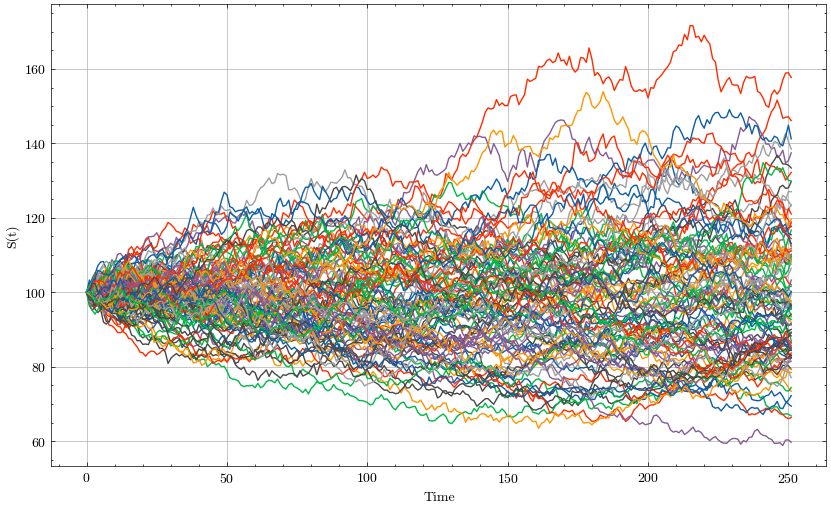

In [115]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

The strike of the call option that we aim to hedge is $K = 100$

## Hedging experiment without transaction costs

In [116]:
ticksize = 0.00
K = 100
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100
discount_rate = 0.0
v_delta_european = vmap(delta_european, in_axes=(0, None, None, None, None))

In [117]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [118]:
def hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    deltas = [v_delta_european(stock_paths[i], K, maturity - i * dt, sigma, discount_rate) for i in range(0, N)]
    cs = [european_price(stock_paths[i], K, maturity - i * dt, sigma, discount_rate, dtype=jnp.float32) for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1] if i != N - 1 else deltas[i]
        transaction_costs = get_transaction_costs(ticksize, ddelta)
        
        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

In [119]:
mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00)

In [120]:
print('Transaction costs: 0.00')
print(f'The mean hedge error is: {mean_hedge_error}')
print(f'The (normalized) standard deviation is: {std_hedge_error}')

Transaction costs: 0.00
The mean hedge error is: 0.008805735036730766
The (normalized) standard deviation is: 0.05654177814722061


### Experiments

In [121]:
results = {
    'Strike': [],
    'Volatility': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [122]:
def update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Volatility'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [123]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.008805735036730766
The normalized std of the hedge error is: 0.05654177814722061


Weekly rebalancing $n=52$

In [124]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [125]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1636512279510498
The normalized std of the hedge error is: 0.27263307571411133


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [126]:
K = 80
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [127]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.040203046053647995
The normalized std of the hedge error is: 0.011829356662929058


Weekly rebalancing $n=52$

In [128]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [129]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03816193342208862
The normalized std of the hedge error is: 0.06476278603076935


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [130]:
K = 90
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [131]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.003282597055658698
The normalized std of the hedge error is: 0.028360243886709213


Weekly rebalancing $n=52$

In [132]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [133]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.4751802086830139
The normalized std of the hedge error is: 0.13485142588615417


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [134]:
K = 110
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [135]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.017115915194153786
The normalized std of the hedge error is: 0.09854724258184433


Weekly rebalancing $n=52$

In [136]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [137]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1694381833076477
The normalized std of the hedge error is: 0.49147239327430725


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [138]:
K = 120
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [139]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.012318539433181286
The normalized std of the hedge error is: 0.20061993598937988


Weekly rebalancing $n=52$

In [140]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [141]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.09602701663970947
The normalized std of the hedge error is: 0.7850357294082642


#### Different maturities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.0 \quad n = 504
$$

In [142]:
K = 100
T = 2.0
N = 504

stock_paths = gmb.sample_paths(T, N, n_sim)

In [143]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.013485667295753956
The normalized std of the hedge error is: 0.041345350444316864


Weekly rebalancing $n=52$

In [144]:
N = 104

stock_paths = gmb.sample_paths(T, N, n_sim)

In [145]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.4834420680999756
The normalized std of the hedge error is: 0.25047770142555237


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.5 \quad n = 121
$$

In [146]:
T = 0.5
N = 121

stock_paths = gmb.sample_paths(T, N, n_sim)

In [147]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.017625372856855392
The normalized std of the hedge error is: 0.08867237716913223


Weekly rebalancing $n=52$

In [148]:
N = 26

stock_paths = gmb.sample_paths(T, N, n_sim)

In [149]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.07440058887004852
The normalized std of the hedge error is: 0.2540748119354248


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.2 \quad n = 50
$$

In [150]:
T = 0.2
N = 50

stock_paths = gmb.sample_paths(T, N, n_sim)

In [151]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.08775626868009567
The normalized std of the hedge error is: 0.12915946543216705


Weekly rebalancing $n=10$

In [152]:
N = 10

stock_paths = gmb.sample_paths(T, N, n_sim)

In [153]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1761336624622345
The normalized std of the hedge error is: 0.32141077518463135


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [154]:
K = 100
T = 1.0
N = 252
sigma = 0.1

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [155]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.013609187677502632
The normalized std of the hedge error is: 0.04853818193078041


Weekly rebalancing $n=52$

In [156]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [157]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.04265468567609787
The normalized std of the hedge error is: 0.2590244710445404


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.3 \quad T = 1.0 \quad n = 252
$$

In [158]:
sigma = 0.3
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [159]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.032393284142017365
The normalized std of the hedge error is: 0.054831039160490036


Weekly rebalancing $n=52$

In [160]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [161]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1791822463274002
The normalized std of the hedge error is: 0.23345324397087097


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.4 \quad T = 1.0 \quad n = 252
$$

In [162]:
sigma = 0.4
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [163]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.0766158178448677
The normalized std of the hedge error is: 0.04978282004594803


Weekly rebalancing $n=52$

In [164]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [165]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.52274090051651
The normalized std of the hedge error is: 0.259317547082901


In [166]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Volatility,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.2,1.0,252,0.008805735,0.05654178
1,100,0.2,1.0,52,0.16365123,0.27263308
2,80,0.2,1.0,252,0.040203046,0.011829357
3,80,0.2,1.0,52,-0.038161933,0.064762786
4,90,0.2,1.0,252,0.003282597,0.028360244
5,90,0.2,1.0,52,0.4751802,0.13485143
6,110,0.2,1.0,252,-0.017115915,0.09854724
7,110,0.2,1.0,52,0.16943818,0.4914724
8,120,0.2,1.0,252,0.012318539,0.20061994
9,120,0.2,1.0,52,-0.09602702,0.7850357


In [167]:
res_df.to_csv('./results/bs_delta_zero.csv')

In [168]:
print(res_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.5f}".format,
)) 

\begin{tabular}{rrrrll}
\toprule
Strike & Volatility & Maturity & Rebalancing_freq & E_PL_T & Std_PL_T \\
\midrule
100 & 0.20000 & 1.00000 & 252 & 0.008805735 & 0.05654178 \\
100 & 0.20000 & 1.00000 & 52 & 0.16365123 & 0.27263308 \\
80 & 0.20000 & 1.00000 & 252 & 0.040203046 & 0.011829357 \\
80 & 0.20000 & 1.00000 & 52 & -0.038161933 & 0.064762786 \\
90 & 0.20000 & 1.00000 & 252 & 0.003282597 & 0.028360244 \\
90 & 0.20000 & 1.00000 & 52 & 0.4751802 & 0.13485143 \\
110 & 0.20000 & 1.00000 & 252 & -0.017115915 & 0.09854724 \\
110 & 0.20000 & 1.00000 & 52 & 0.16943818 & 0.4914724 \\
120 & 0.20000 & 1.00000 & 252 & 0.012318539 & 0.20061994 \\
120 & 0.20000 & 1.00000 & 52 & -0.09602702 & 0.7850357 \\
100 & 0.20000 & 2.00000 & 504 & -0.013485667 & 0.04134535 \\
100 & 0.20000 & 2.00000 & 104 & 0.48344207 & 0.2504777 \\
100 & 0.20000 & 0.50000 & 121 & 0.017625373 & 0.08867238 \\
100 & 0.20000 & 0.50000 & 26 & 0.07440059 & 0.2540748 \\
100 & 0.20000 & 0.20000 & 50 & 0.08775627 & 0.12915947 \\
1

## Hedging experiment with low transaction costs

In [169]:
ticksize = 0.01
K = 100
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(maturity, N, n_sim)

### Experiments

In [170]:
results = {
    'Strike': [],
    'Volatility': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [171]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.09866348654031754
The normalized std of the hedge error is: 0.07033218443393707


Weekly rebalancing $n=52$

In [172]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [173]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.04338907450437546
The normalized std of the hedge error is: 0.25217175483703613


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [174]:
K = 80
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [175]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03331107273697853
The normalized std of the hedge error is: 0.01136992871761322


Weekly rebalancing $n=52$

In [176]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [177]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07221522927284241
The normalized std of the hedge error is: 0.06577243655920029


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [178]:
K = 90
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [179]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0076886797323822975
The normalized std of the hedge error is: 0.024766961112618446


Weekly rebalancing $n=52$

In [180]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [181]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08913760632276535
The normalized std of the hedge error is: 0.11554386466741562


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [182]:
K = 110
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [183]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0708906278014183
The normalized std of the hedge error is: 0.10863503068685532


Weekly rebalancing $n=52$

In [184]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [185]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.41906705498695374
The normalized std of the hedge error is: 0.46639710664749146


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [186]:
K = 120
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [187]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.047583434730768204
The normalized std of the hedge error is: 0.17308533191680908


Weekly rebalancing $n=52$

In [188]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [189]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.4131929576396942
The normalized std of the hedge error is: 1.0568300485610962


#### Different maturities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.0 \quad n = 504
$$

In [190]:
K = 100
T = 2.0
N = 504

stock_paths = gmb.sample_paths(T, N, n_sim)

In [191]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.013225068338215351
The normalized std of the hedge error is: 0.03726714849472046


Weekly rebalancing $n=52$

In [192]:
N = 104

stock_paths = gmb.sample_paths(T, N, n_sim)

In [193]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.11407305300235748
The normalized std of the hedge error is: 0.22289785742759705


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.5 \quad n = 121
$$

In [194]:
T = 0.5
N = 121

stock_paths = gmb.sample_paths(T, N, n_sim)

In [195]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.003321616677567363
The normalized std of the hedge error is: 0.07955954223871231


Weekly rebalancing $n=52$

In [196]:
N = 26

stock_paths = gmb.sample_paths(T, N, n_sim)

In [197]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.2935905456542969
The normalized std of the hedge error is: 0.26949208974838257


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.2 \quad n = 50
$$

In [198]:
T = 0.2
N = 50

stock_paths = gmb.sample_paths(T, N, n_sim)

In [199]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.004807575605809689
The normalized std of the hedge error is: 0.12665659189224243


Weekly rebalancing $n=10$

In [200]:
N = 10

stock_paths = gmb.sample_paths(T, N, n_sim)

In [201]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.2517801821231842
The normalized std of the hedge error is: 0.35000476241111755


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [202]:
K = 100
T = 1.0
N = 252
sigma = 0.1

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [203]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.06770090013742447
The normalized std of the hedge error is: 0.052573349326848984


Weekly rebalancing $n=52$

In [204]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [205]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.025253145024180412
The normalized std of the hedge error is: 0.2315567284822464


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.3 \quad T = 1.0 \quad n = 252
$$

In [206]:
sigma = 0.3
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [207]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.01909090392291546
The normalized std of the hedge error is: 0.061540521681308746


Weekly rebalancing $n=52$

In [208]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [209]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.15751780569553375
The normalized std of the hedge error is: 0.2531595528125763


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.4 \quad T = 1.0 \quad n = 252
$$

In [210]:
sigma = 0.4
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [211]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.06440791487693787
The normalized std of the hedge error is: 0.06130305305123329


Weekly rebalancing $n=52$

In [212]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [213]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.014929980970919132
The normalized std of the hedge error is: 0.23932209610939026


In [214]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Volatility,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.2,1.0,252,-0.09866349,0.070332184
1,100,0.2,1.0,52,0.043389075,0.25217175
2,80,0.2,1.0,252,-0.033311073,0.011369929
3,80,0.2,1.0,52,0.07221523,0.06577244
4,90,0.2,1.0,252,-0.0076886797,0.024766961
5,90,0.2,1.0,52,-0.08913761,0.115543865
6,110,0.2,1.0,252,-0.07089063,0.10863503
7,110,0.2,1.0,52,0.41906705,0.4663971
8,120,0.2,1.0,252,0.047583435,0.17308533
9,120,0.2,1.0,52,0.41319296,1.05683


In [215]:
res_df.to_csv('./results/bs_delta_low.csv')

In [216]:
print(res_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.5f}".format,
)) 

\begin{tabular}{rrrrll}
\toprule
Strike & Volatility & Maturity & Rebalancing_freq & E_PL_T & Std_PL_T \\
\midrule
100 & 0.20000 & 1.00000 & 252 & -0.09866349 & 0.070332184 \\
100 & 0.20000 & 1.00000 & 52 & 0.043389075 & 0.25217175 \\
80 & 0.20000 & 1.00000 & 252 & -0.033311073 & 0.011369929 \\
80 & 0.20000 & 1.00000 & 52 & 0.07221523 & 0.06577244 \\
90 & 0.20000 & 1.00000 & 252 & -0.0076886797 & 0.024766961 \\
90 & 0.20000 & 1.00000 & 52 & -0.08913761 & 0.115543865 \\
110 & 0.20000 & 1.00000 & 252 & -0.07089063 & 0.10863503 \\
110 & 0.20000 & 1.00000 & 52 & 0.41906705 & 0.4663971 \\
120 & 0.20000 & 1.00000 & 252 & 0.047583435 & 0.17308533 \\
120 & 0.20000 & 1.00000 & 52 & 0.41319296 & 1.05683 \\
100 & 0.20000 & 2.00000 & 504 & -0.013225068 & 0.03726715 \\
100 & 0.20000 & 2.00000 & 104 & 0.11407305 & 0.22289786 \\
100 & 0.20000 & 0.50000 & 121 & -0.0033216167 & 0.07955954 \\
100 & 0.20000 & 0.50000 & 26 & 0.29359055 & 0.2694921 \\
100 & 0.20000 & 0.20000 & 50 & 0.0048075756 & 0.1266565

## Hedging experiment with high transaction costs

In [217]:
ticksize = 0.05
K = 100
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(maturity, N, n_sim)

### Experiments

In [218]:
results = {
    'Strike': [],
    'Volatility': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [219]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2600295841693878
The normalized std of the hedge error is: 0.05068967118859291


Weekly rebalancing $n=52$

In [220]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [221]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.18047577142715454
The normalized std of the hedge error is: 0.23047268390655518


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [222]:
K = 80
sigma = 0.2
maturity = 1.0
N = 252
n_sim = 100

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [223]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.17520689964294434
The normalized std of the hedge error is: 0.015395021066069603


Weekly rebalancing $n=52$

In [224]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [225]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.012147121131420135
The normalized std of the hedge error is: 0.06422887742519379


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [226]:
K = 90
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [227]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.19346190989017487
The normalized std of the hedge error is: 0.026296943426132202


Weekly rebalancing $n=52$

In [228]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [229]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.12390121072530746
The normalized std of the hedge error is: 0.1330375373363495


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [230]:
K = 110
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [231]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.21086406707763672
The normalized std of the hedge error is: 0.11073312908411026


Weekly rebalancing $n=52$

In [232]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [233]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.04133616015315056
The normalized std of the hedge error is: 0.5084012150764465


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [234]:
K = 120
N = 252

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [235]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.146034374833107
The normalized std of the hedge error is: 0.17786936461925507


Weekly rebalancing $n=52$

In [236]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [237]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.24940791726112366
The normalized std of the hedge error is: 0.9637081623077393


#### Different maturities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.0 \quad n = 504
$$

In [238]:
K = 100
T = 2.0
N = 504

stock_paths = gmb.sample_paths(T, N, n_sim)

In [239]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.43185847997665405
The normalized std of the hedge error is: 0.03790391981601715


Weekly rebalancing $n=52$

In [240]:
N = 104

stock_paths = gmb.sample_paths(T, N, n_sim)

In [241]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.003939948044717312
The normalized std of the hedge error is: 0.22694382071495056


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.5 \quad n = 121
$$

In [242]:
T = 0.5
N = 121

stock_paths = gmb.sample_paths(T, N, n_sim)

In [243]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.3165569007396698
The normalized std of the hedge error is: 0.09658921509981155


Weekly rebalancing $n=52$

In [244]:
N = 26

stock_paths = gmb.sample_paths(T, N, n_sim)

In [245]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.04010603949427605
The normalized std of the hedge error is: 0.27661997079849243


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.2 \quad n = 50
$$

In [246]:
T = 0.2
N = 50

stock_paths = gmb.sample_paths(T, N, n_sim)

In [247]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.1401529312133789
The normalized std of the hedge error is: 0.11571183800697327


Weekly rebalancing $n=10$

In [248]:
N = 10

stock_paths = gmb.sample_paths(T, N, n_sim)

In [249]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.1785803884267807
The normalized std of the hedge error is: 0.3048037588596344


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [250]:
K = 100
T = 1.0
N = 252
sigma = 0.1

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [251]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.2911815643310547
The normalized std of the hedge error is: 0.06623535603284836


Weekly rebalancing $n=52$

In [252]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [253]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.05856146663427353
The normalized std of the hedge error is: 0.24316610395908356


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.3 \quad T = 1.0 \quad n = 252
$$

In [254]:
sigma = 0.3
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [255]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.25433072447776794
The normalized std of the hedge error is: 0.0583072267472744


Weekly rebalancing $n=52$

In [256]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [257]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.1093917042016983
The normalized std of the hedge error is: 0.2610054612159729


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.4 \quad T = 1.0 \quad n = 252
$$

In [258]:
sigma = 0.4
N = 252

gmb = UnivGeometricBrownianMotion(s0, mean, sigma, dtype=jnp.float32)
stock_paths = gmb.sample_paths(T, N, n_sim)

In [259]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.23825585842132568
The normalized std of the hedge error is: 0.059392377734184265


Weekly rebalancing $n=52$

In [260]:
N = 52

stock_paths = gmb.sample_paths(maturity, N, n_sim)

In [261]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.12669746577739716
The normalized std of the hedge error is: 0.24862520396709442


In [262]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Volatility,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.2,1.0,252,-0.26002958,0.05068967
1,100,0.2,1.0,52,-0.18047577,0.23047268
2,80,0.2,1.0,252,-0.1752069,0.015395021
3,80,0.2,1.0,52,-0.012147121,0.06422888
4,90,0.2,1.0,252,-0.19346191,0.026296943
5,90,0.2,1.0,52,0.12390121,0.13303754
6,110,0.2,1.0,252,-0.21086407,0.11073313
7,110,0.2,1.0,52,0.04133616,0.5084012
8,120,0.2,1.0,252,-0.14603437,0.17786936
9,120,0.2,1.0,52,0.24940792,0.96370816


In [263]:
res_df.to_csv('./results/bs_delta_high.csv')

In [264]:
print(res_df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.5f}".format,
)) 

\begin{tabular}{rrrrll}
\toprule
Strike & Volatility & Maturity & Rebalancing_freq & E_PL_T & Std_PL_T \\
\midrule
100 & 0.20000 & 1.00000 & 252 & -0.26002958 & 0.05068967 \\
100 & 0.20000 & 1.00000 & 52 & -0.18047577 & 0.23047268 \\
80 & 0.20000 & 1.00000 & 252 & -0.1752069 & 0.015395021 \\
80 & 0.20000 & 1.00000 & 52 & -0.012147121 & 0.06422888 \\
90 & 0.20000 & 1.00000 & 252 & -0.19346191 & 0.026296943 \\
90 & 0.20000 & 1.00000 & 52 & 0.12390121 & 0.13303754 \\
110 & 0.20000 & 1.00000 & 252 & -0.21086407 & 0.11073313 \\
110 & 0.20000 & 1.00000 & 52 & 0.04133616 & 0.5084012 \\
120 & 0.20000 & 1.00000 & 252 & -0.14603437 & 0.17786936 \\
120 & 0.20000 & 1.00000 & 52 & 0.24940792 & 0.96370816 \\
100 & 0.20000 & 2.00000 & 504 & -0.43185848 & 0.03790392 \\
100 & 0.20000 & 2.00000 & 104 & -0.003939948 & 0.22694382 \\
100 & 0.20000 & 0.50000 & 121 & -0.3165569 & 0.096589215 \\
100 & 0.20000 & 0.50000 & 26 & -0.04010604 & 0.27661997 \\
100 & 0.20000 & 0.20000 & 50 & -0.14015293 & 0.11571184 